In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [2]:
fname_spc = '../data/spc_giants.csv' # original
fname_spc = '../data/smear_spc_new.txt' # updated 
fname_spc = '../data/SMEAR_SPC_first_iteration.txt' # new targets
fname_spc = '../data/smear_spc_2.txt' # new targets 
fname_spc = '../data/SMEAR_reiterated.txt'

fname_guy = '../data/smear_Dnu.csv' 

In [3]:
spc_data = Table.read(fname_spc,format='ascii')

guy_data = Table.read(fname_guy,format='ascii')
guy_data.rename_column('Star_ID','Object')
print(guy_data.keys())
print(spc_data.keys())

['Object', 'Dnu', 'Dnu_err', 'Numax', 'Numax_err', 'eps', 'eps_err']
['Object', 'BJD_TDB', 'RV', 'RVerr', 'Teff', 'Teff_err', 'logg', 'logg_err', 'monh', 'monh_err', 'vsini', 'vsini_err', 'CCF', 'SNRe', 'n_aps', 'exptime', 'spectro', 'res', 'method']


In [4]:
spc_data

Object,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+43_3171,2457671.586446,-16.325,0.11,3655.87,50,1.137,0.1,-1.203,0.08,4.54,0.5,0.992,68.9,3,250.0,tres,m,SPC2.9
HD_174020,2457670.580448,-14.835,0.077,3780.53,50,1.24,0.1,-1.033,0.08,5.38,0.5,0.9832,120.1,3,200.0,tres,m,SPC2.9
HD_180682,2457672.569455,30.986,0.071,4076.96,50,1.429,0.1,-1.034,0.08,5.75,0.5,0.9792,80.1,3,80.0,tres,m,SPC2.9
HD_181022,2457647.609269,-80.388,0.16,3556.71,50,1.032,0.1,-1.63,0.08,4.68,0.5,1.0026,108.8,3,120.0,tres,m,SPC2.9


In [5]:
new_stars = ['HD_175466','BD+42_3150','BD+48_2904','HD_176209','HD_182354','HD_189636B','HD_189636A','HD_189750']

In [6]:
for star in new_stars:
    if star in guy_data['Object']:
        print(star)

BD+42_3150
BD+48_2904
HD_182354
HD_189750


In [7]:
guy_data.sort('Object')
spc_data.sort('Object')

In [8]:
spc_data

Object,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+43_3171,2457671.586446,-16.325,0.11,3655.87,50,1.137,0.1,-1.203,0.08,4.54,0.5,0.992,68.9,3,250.0,tres,m,SPC2.9
HD_174020,2457670.580448,-14.835,0.077,3780.53,50,1.24,0.1,-1.033,0.08,5.38,0.5,0.9832,120.1,3,200.0,tres,m,SPC2.9
HD_180682,2457672.569455,30.986,0.071,4076.96,50,1.429,0.1,-1.034,0.08,5.75,0.5,0.9792,80.1,3,80.0,tres,m,SPC2.9
HD_181022,2457647.609269,-80.388,0.16,3556.71,50,1.032,0.1,-1.63,0.08,4.68,0.5,1.0026,108.8,3,120.0,tres,m,SPC2.9


In [9]:
numax_sun = 3160.
numax_sun_err = 10.

Teff_sun = 5777.
logg_sun = 4.43812

In [10]:
mapping = np.array([np.where(guy_data['Object'][:]==obj)[0][0] for obj in spc_data['Object'] if (obj in guy_data['Object'])])
missing = np.array([obj not in guy_data['Object'] for obj in spc_data['Object']])

In [11]:
# new_table = join(guy_data[mapping],spc_data[~missing])
new_table = join(guy_data,spc_data)

In [12]:
# spc_data['Object'].pprint(max_lines=70)

In [13]:
# new_table.keys()

In [14]:
g = ((new_table['Teff']/Teff_sun)**0.5) * (new_table['Numax']/numax_sun)
log_g = np.log10(g)+logg_sun

In [15]:
# new_table['logg']

## Now we do it with Monte Carlo

In [16]:
teffs = new_table['Teff'] 
numaxes = new_table['Numax']
numax_errs = new_table['Numax_err']
N = len(teffs)

# data = dict(teff=teffs,mu_numax=numaxes,sig_numax=numax_errs,numax_sun=numax_sun,teff_sun=Teff_sun,N=N)

In [17]:
log_g = []
log_g_err = []

for j in range(N):
    thisnumax = numax_errs[j]*np.random.randn(10000)+numaxes[j]
    thislogg = np.log10((teffs[j]/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

(array([1., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([25.40266557, 28.12506446, 30.84746334, 33.56986222, 36.29226111,
        39.01465999, 41.73705887, 44.45945776, 47.18185664, 49.90425553,
        52.62665441]),
 <a list of 10 Patch objects>)

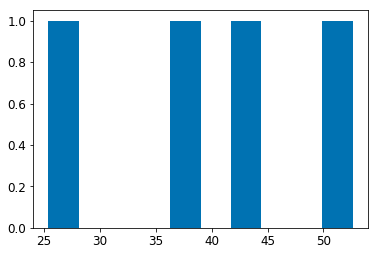

In [18]:
plt.hist(numaxes/numax_errs)

In [19]:
new_table['Object'].pprint(max_lines=40)

  Object  
----------
BD+43_3171
 HD_174020
 HD_180682
 HD_181022


In [20]:
output = Table({'Object':new_table['Object'],
                'numax':numaxes,
                'numax_err':numax_errs,
                'log_g':log_g,
                'log_g_err':log_g_err})
output = output['Object','numax','numax_err','log_g','log_g_err']
output.write('pope_asteroseismology_newtargs_again.csv',format='csv')

In [21]:
output

Object,numax,numax_err,log_g,log_g_err
str10,float64,float64,float64,float64
BD+43_3171,1.984298734336489,0.05145104900196677,1.1364791666620775,0.011390141817108594
HD_174020,2.47548965209216,0.09744999575175439,1.239695792873309,0.01733490776836783
HD_180682,3.6778316522927974,0.08410834299831177,1.4282941006820926,0.010094708240302787
HD_181022,1.5797194213025423,0.03001747762631546,1.031637538652579,0.008335678784442148


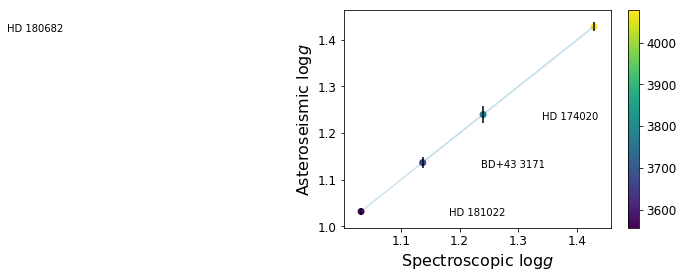

In [22]:
plt.scatter(new_table['logg'],log_g,c=new_table['Teff'])
plt.errorbar(new_table['logg'],log_g,yerr=log_g_err,linestyle='',color='k')
plt.colorbar()
offsets = [0.1,0.1, -1.0,0.15]
for j in range(len(new_table)):
    plt.text(new_table['logg'][j]+offsets[j],log_g[j]-0.01,new_table['Object'][j].replace('_',' '))
plt.plot(new_table['logg'],new_table['logg'],'-',alpha=0.2)
plt.xlabel(r'Spectroscopic $\log{g}$')
plt.ylabel(r'Asteroseismic $\log{g}$')
plt.savefig('numax_correlation.png')

In [23]:
new_table

Object,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+43_3171,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567,2457671.586446,-16.325,0.11,3655.87,50,1.137,0.1,-1.203,0.08,4.54,0.5,0.992,68.9,3,250.0,tres,m,SPC2.9
HD_174020,0.5639183284003043,0.01603666749035637,2.47548965209216,0.09744999575175439,0.8926590744791576,0.08467569516842773,2457670.580448,-14.835,0.077,3780.53,50,1.24,0.1,-1.033,0.08,5.38,0.5,0.9832,120.1,3,200.0,tres,m,SPC2.9
HD_180682,0.7677383130078999,0.05478793614233027,3.6778316522927974,0.08410834299831177,1.0678558385995771,0.14565236474481066,2457672.569455,30.986,0.071,4076.96,50,1.429,0.1,-1.034,0.08,5.75,0.5,0.9792,80.1,3,80.0,tres,m,SPC2.9
HD_181022,0.37622783732353315,0.010867870516783215,1.5797194213025423,0.03001747762631546,0.7033017339945093,0.10056465472259418,2457647.609269,-80.388,0.16,3556.71,50,1.032,0.1,-1.63,0.08,4.68,0.5,1.0026,108.8,3,120.0,tres,m,SPC2.9


In [24]:
# output

In [25]:
spc_data['Object'].pprint(max_lines=70)

  Object  
----------
BD+43_3171
 HD_174020
 HD_180682
 HD_181022


In [26]:
# bad targets BD+433171, HD174020, HD180682 and HD181022
bad = ['BD+43_3171', 'BD+43_3213','HD_174020', 'HD_180682', 'HD_181022']

In [27]:
fname_old = '../data/spc_giants.csv' # original
old_data = Table.read(fname_old)

In [28]:
for target in bad:
    test = old_data[old_data['Object']==target]['Object','Teff','logg','monh']
    print(test)

  Object     Teff   logg  monh 
---------- ------- ----- ------
BD+43_3171 4071.77 2.025 -0.167
  Object     Teff   logg  monh
---------- ------- ----- -----
BD+43_3213 4131.24 2.074 0.073
  Object    Teff   logg monh
--------- ------- ----- ----
HD_174020 4161.69 1.973 -0.1
  Object    Teff   logg  monh 
--------- ------- ----- ------
HD_180682 4409.94 2.141 -0.507
  Object    Teff   logg  monh 
--------- ------- ----- ------
HD_181022 4044.81 2.058 -0.277


In [29]:
m = [np.where(old_data['Object']==target)[0][0] for target in bad]
old_data[m]['Object','Teff','logg','monh']

Object,Teff,logg,monh
str10,float64,float64,float64
BD+43_3171,4071.77,2.025,-0.167
BD+43_3213,4131.24,2.074,0.073
HD_174020,4161.69,1.973,-0.1
HD_180682,4409.94,2.141,-0.507
HD_181022,4044.81,2.058,-0.277


In [30]:
spc_data['Object','Teff','logg','monh']

Object,Teff,logg,monh
str10,float64,float64,float64
BD+43_3171,3655.87,1.137,-1.203
HD_174020,3780.53,1.24,-1.033
HD_180682,4076.96,1.429,-1.034
HD_181022,3556.71,1.032,-1.63


### Now using SED Fits from http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/MNRAS/471/770

In [31]:
bad

['BD+43_3171', 'BD+43_3213', 'HD_174020', 'HD_180682', 'HD_181022']

In [32]:
# BD+43_3171: 3820 +- 196 K (Tycho-Gaia)
# BD+43_3213: None in either
# HD 174020: 4008 +- 125 K (Hipparcos-Gaia)
# HD 180682: 4253 +- 125 K (Hipparcos-Gaia)
# HD 181022: 3743 +- 125 K (Hipparcos-Gaia)

In [33]:
bad_names = ['BD+43_3171', 'HD_174020', 'HD_180682', 'HD_181022']

bad_teffs = [3820,4008,4253,3743]
bad_teff_errs = [196,125,125,125]

log_g = []
log_g_err = []

for j, star in enumerate(bad_names):
    teff = bad_teffs[j]
    teff_err = bad_teff_errs[j]
    m = (guy_data['Object']==star)
    numax, numax_err = (guy_data[m]['Numax'], guy_data[m]['Numax_err'])

    thisnumax = numax_err*np.random.randn(10000)+numax
    thislogg = np.log10((teff/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

output = Table({'Object':bad_names,
                'teff':bad_teffs,
                'e_teff':bad_teff_errs,
                'provenance':['tycho','hip','hip','hip'],
                'log_g':log_g,
                'log_g_err':log_g_err})

output.write('pope_asteroseismology_badstars.csv',format='csv',overwrite=True)

In [34]:
bad_names = ['BD+43_3171', 'HD_174020', 'HD_180682', 'HD_181022']

bad_teffs = [3820,4008,4253,3743]
bad_teff_errs = [196,125,125,125]

m = (guy_data['Object']==bad_names[0])
guy_data[m]

Object,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str10,float64,float64,float64,float64,float64,float64
BD+43_3171,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567


In [35]:
output

Object,teff,e_teff,provenance,log_g,log_g_err
str10,int64,int64,str5,float64,float64
BD+43_3171,3820,196,tycho,1.1461613004179467,0.011210226433082228
HD_174020,4008,125,hip,1.2522844180931743,0.017255238931521047
HD_180682,4253,125,hip,1.4374537654267705,0.00995392638864144
HD_181022,3743,125,hip,1.0428238491932422,0.008213441822240878
